<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/04_DistillBERT_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
PROJECT_DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PROJECT_DRIVE_DIR, exist_ok=True)
print("Drive project folder:", PROJECT_DRIVE_DIR)

Mounted at /content/drive
Drive project folder: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [2]:
cd {PROJECT_DRIVE_DIR}

/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [3]:
import torch, numpy as np, pandas as pd
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

In [4]:
RANDOM_SEED = 42
TEXT_COL, LABEL_COL = "Review", "y"
label_names = {0:"negative", 1:"neutral", 2:"positive"}

MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 256
BATCH_TRAIN = 16
BATCH_EVAL  = 32
EPOCHS = 3
LR = 2e-5

# class_weights from the prevous model
class_weights = {0: 2.1247, 1: 3.1287, 2: 0.4525}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Load prepared file
df_cleaned = pd.read_csv("data/tripadvisor_prepared_3class.csv")

LABEL_COL = "y"
TEXT_COL  = "text"

RANDOM_SEED = 42
train_df, test_df = train_test_split(
    df_cleaned[[TEXT_COL, LABEL_COL]], test_size=0.15, random_state=RANDOM_SEED,
    stratify=df_cleaned[LABEL_COL]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1765, random_state=RANDOM_SEED,  # ~15% of total
    stratify=train_df[LABEL_COL]
)

In [6]:
print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

Train=14342, Val=3075, Test=3074


In [12]:
!pip install -U transformers

In [16]:
import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments

def tok(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=MAX_LEN)

train_ds = Dataset.from_pandas(train_df[[TEXT_COL, LABEL_COL]].reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, LABEL_COL]].reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, LABEL_COL]].reset_index(drop=True))

train_ds = train_ds.map(tok, batched=True).rename_column(LABEL_COL, "labels")
val_ds   = val_ds.map(tok, batched=True).rename_column(LABEL_COL, "labels")
test_ds  = test_ds.map(tok, batched=True).rename_column(LABEL_COL, "labels")

cols = ["input_ids","attention_mask","labels"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

cw = torch.tensor([class_weights[i] for i in range(3)], dtype=torch.float)

class WeightedTrainer(Trainer):
    # accept extra kwargs from Trainer (e.g., num_items_in_batch)
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=cw.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    p,r,f1w,_ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "f1_macro": f1m, "precision_w": p, "recall_w": r, "f1_weighted": f1w}

args = TrainingArguments(
    output_dir="runs/distilbert_tripadvisor",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    seed=RANDOM_SEED,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=[],
)
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds.shuffle(seed=RANDOM_SEED),
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
print("Val:", trainer.evaluate(val_ds))
print("Test:", trainer.evaluate(test_ds))

Map:   0%|          | 0/14342 [00:00<?, ? examples/s]

Map:   0%|          | 0/3075 [00:00<?, ? examples/s]

Map:   0%|          | 0/3074 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5606703.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
50,1.020600
100,0.865200
150,0.697200
200,0.579500
250,0.654000
300,0.675500
350,0.568700
400,0.621700
450,0.632900
500,0.629000


Val: {'eval_loss': 0.6738335490226746, 'eval_accuracy': 0.863739837398374, 'eval_f1_macro': 0.7552662597921457, 'eval_precision_w': 0.8825454756018507, 'eval_recall_w': 0.863739837398374, 'eval_f1_weighted': 0.871614600307333, 'eval_runtime': 5.8569, 'eval_samples_per_second': 525.019, 'eval_steps_per_second': 16.562, 'epoch': 3.0}
Test: {'eval_loss': 0.6422139406204224, 'eval_accuracy': 0.8692257644762524, 'eval_f1_macro': 0.7591476420578515, 'eval_precision_w': 0.8852707924750463, 'eval_recall_w': 0.8692257644762524, 'eval_f1_weighted': 0.8760106350750134, 'eval_runtime': 5.5149, 'eval_samples_per_second': 557.397, 'eval_steps_per_second': 17.589, 'epoch': 3.0}


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)
print(classification_report(y_true, y_pred, target_names=["negative","neutral","positive"]))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
print("Confusion matrix (test):\n", cm)

              precision    recall  f1-score   support

    negative       0.83      0.85      0.84       482
     neutral       0.45      0.57      0.50       328
    positive       0.96      0.92      0.94      2264

    accuracy                           0.87      3074
   macro avg       0.75      0.78      0.76      3074
weighted avg       0.89      0.87      0.88      3074

Confusion matrix (test):
 [[ 408   66    8]
 [  64  188   76]
 [  21  167 2076]]


In [18]:
import torch, numpy as np
val_logits = trainer.predict(val_ds).predictions
test_logits = preds.predictions
val_probs  = torch.softmax(torch.tensor(val_logits), dim=-1).numpy()
test_probs = torch.softmax(torch.tensor(test_logits), dim=-1).numpy()

from sklearn.metrics import f1_score
y_val = trainer.predict(val_ds).label_ids

best_f1, best_t = -1, 0.33
for t in np.linspace(0.30, 0.55, 11):
    p = val_probs.argmax(1)
    p[val_probs[:,1] >= t] = 1
    f1m = f1_score(y_val, p, average="macro")
    if f1m > best_f1: best_f1, best_t = f1m, t
print("Best neutral threshold:", round(best_t,3), "val macro-F1:", round(best_f1,4))

p_test = test_probs.argmax(1)
p_test[test_probs[:,1] >= best_t] = 1
print("Test macro-F1 (thresholded):", f1_score(y_true, p_test, average="macro"))

Best neutral threshold: 0.5 val macro-F1: 0.7553
Test macro-F1 (thresholded): 0.7591476420578515


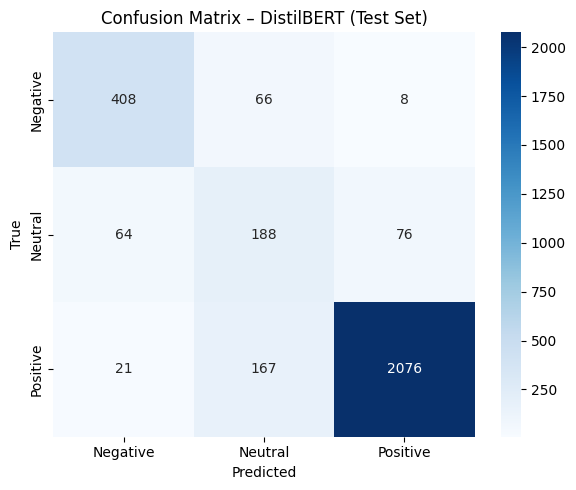

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – DistilBERT (Test Set)")
plt.tight_layout()
plt.show()

In [20]:
trainer.save_model("models/distilbert_tripadvisor")
tokenizer.save_pretrained("models/distilbert_tripadvisor")

('models/distilbert_tripadvisor/tokenizer_config.json',
 'models/distilbert_tripadvisor/special_tokens_map.json',
 'models/distilbert_tripadvisor/vocab.txt',
 'models/distilbert_tripadvisor/added_tokens.json',
 'models/distilbert_tripadvisor/tokenizer.json')

In [22]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model
MODEL_DIR   = "models/distilbert_tripadvisor"
MAX_LEN     = 256
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Inference helper
def predict_sentiment_bert(texts, batch_size=256, neutral_threshold=None):
    """
    texts: list[str]
    neutral_threshold: float or None. If set (e.g., 0.50), upgrade any sample to 'neutral'
                       when P(neutral) >= threshold. Leave None to use plain argmax.
    Returns: dict with 'labels' (ints), 'names' (strings), 'probs' (np.array n x 3)
    """
    preds, probs = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt"
        )
        enc = {k:v.to(DEVICE) for k,v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits
            p = torch.softmax(logits, dim=-1).cpu().numpy()

        if neutral_threshold is not None:
            argmax = p.argmax(axis=1)
            neu_mask = p[:, 1] >= neutral_threshold
            argmax[neu_mask] = 1
            preds.extend(argmax.tolist())
        else:
            preds.extend(p.argmax(axis=1).tolist())

        probs.append(p)

    probs = np.vstack(probs)
    names = [label_map[i] for i in preds]
    return {"labels": np.array(preds, dtype=int), "names": names, "probs": probs}

# Example
texts = [
    "The place was amazing and the host was very friendly!",
    "It was okay, not great but not terrible either.",
    "Terrible experience — the room was dirty and noisy."
]

out = predict_sentiment_bert(texts)
print(out["labels"])
print(out["names"])


[2 1 0]
['positive', 'neutral', 'negative']
